# Modelling

### Libraries

In [1]:
# import libraries

import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Data

In [2]:
# load negative, neutral and positive time series

negative_reviews_per_month = pd.read_csv('features/negative_reviews_per_month.csv', index_col=0, parse_dates=True)
neutral_reviews_per_month = pd.read_csv('features/neutral_reviews_per_month.csv', index_col=0, parse_dates=True)
positive_reviews_per_month = pd.read_csv('features/positive_reviews_per_month.csv', index_col=0, parse_dates=True)

In [3]:
# load sentiment time series

sentiment_per_month = pd.read_csv('features/sentiment_per_month.csv', index_col=0, parse_dates=True)

In [4]:
# load categories time series

sentiment_restaurants_per_month = pd.read_csv('features/sentiment_restaurants_per_month.csv', index_col=0, parse_dates=True)
sentiment_nightlife_per_month = pd.read_csv('features/sentiment_nightlife_per_month.csv', index_col=0, parse_dates=True)
sentiment_breakfast_brunch_per_month = pd.read_csv('features/sentiment_breakfast_brunch_per_month.csv', index_col=0, parse_dates=True)

### Models

In [5]:
# load ARMA models

negative_arimax = joblib.load('models/negative_arimax.pkl')
neutral_arimax = joblib.load('models/neutral_arimax.pkl')
positive_arimax = joblib.load('models/positive_arimax.pkl')

sentiment_arma = joblib.load('models/sentiment_arima.pkl')

restaurant_arma = joblib.load('models/restaurant_arima.pkl')
nightlife_arma = joblib.load('models/nightlife_arima.pkl')
breakfast_brunch_arma = joblib.load('models/breakfast_brunch_arima.pkl')

In [6]:
def baseline_model(data, method='mean'):
    '''
    Baseline model to predict the next value in a time series
    '''
    if method == 'mean':
        return data.mean()
    elif method == 'median':
        return data.median()
    elif method == 'naive':
        return data.iloc[-1]
    else:
        raise ValueError('Method not supported')

In [7]:
def ses_model(data):
    '''
    Simple Exponential Smoothing model
    '''
    model = SimpleExpSmoothing(data)
    fitted_model = model.fit()
    prediction = fitted_model.forecast(1)
    return prediction.iloc[0]

In [8]:
def holt_linear_damped_model(data):
    '''
    Holt Linear Trend model with damping
    '''
    model = ExponentialSmoothing(data, trend='add', damped_trend=True)
    fitted_model = model.fit()
    prediction = fitted_model.forecast(1)
    return prediction.iloc[0]

In [9]:
models = {
    'baseline_mean': lambda x: baseline_model(x, method='mean'),
    'baseline_median': lambda x: baseline_model(x, method='median'),
    'baseline_naive': lambda x: baseline_model(x, method='naive'),
    'ses': lambda x: ses_model(x),
    'holt_linear_damped': lambda x: holt_linear_damped_model(x)
}

variables = []

### Predictions

In [10]:
# lambda values

lambda_negative = 0.2
lambda_neutral = 0.2
lambda_positive = 0.2
lambda_sentiment = 2
lambda_restaurants = 0.5
lambda_nightlife = 0.5
lambda_breakfast_brunch = 0.5

In [11]:
def inverse_boxcox(transformed_y, lambda_value):
    '''
    Function to inverse Box-Cox transformation (to obtain forecast in original scale)
    '''
    if lambda_value == 0:
        return np.exp(transformed_y)
    else:
        return np.exp(np.log(transformed_y * lambda_value + 1) / lambda_value)

In [12]:
def cross_validation_predictions(data, model, min_train_size=12):
    '''
    Function to perform cross-validation and obtain predictions
    '''
    results = []
    for i in range(min_train_size, len(data)):
        train = data.iloc[:i]
        test = data.iloc[i:i+1]
        prediction = model(train)
        if not test.empty:
            result_entry = {'date': test.index[0], 'actual': test.iloc[0], 'prediction': prediction}
            results.append(result_entry)
    return pd.DataFrame(results)

### Evaluation

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Mean Absolute Percentage Error (MAPE) metric
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    '''
    Mean Absolute Scaled Error (MASE) metric
    '''
    y_true, y_pred, y_train = np.array(y_true), np.array(y_pred), np.array(y_train)
    naive_forecast = y_train[1:] - y_train[:-1]
    mae_naive = np.mean(np.abs(naive_forecast))
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    mase = mae_forecast / mae_naive
    return mase

In [15]:
def evaluate(y_true, y_pred):
    '''
    Evaluate the model using different metrics
    '''
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, mse, rmse, mape

In [16]:
def evaluate_and_plot_best(data, used_lambda, comparison='MSE', extra_models={}, extra_variables=[]):
    '''
    Evaluate the best model and plot the results
    '''
    best_model = None
    best_comparison = float('inf')
    best_results = None
    results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MASE'])
    to_be_used_models = list(models.items()) + list(extra_models.items())
    to_be_used_models = dict(to_be_used_models)
    for model_name, model in to_be_used_models.items():
        for variable in variables+extra_variables:
            exam_data = data.copy()[variable]
            exam_data = exam_data.dropna()
            predictions = cross_validation_predictions(exam_data, model)
            predictions['prediction'] = inverse_boxcox(predictions['prediction'], used_lambda)
            predictions['actual'] = inverse_boxcox(predictions['actual'], used_lambda)
            mae, mse, rmse, mape = evaluate(predictions['actual'], predictions['prediction'])
            mase = mean_absolute_scaled_error(predictions['actual'], predictions['prediction'], exam_data)
            results = pd.concat([results, pd.DataFrame({'Model': model_name + '_' + variable, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}, index=[0])], ignore_index=True)
            if results.iloc[-1][comparison] < best_comparison:
                best_comparison = results.iloc[-1][comparison]
                best_model = model_name + '_' + variable
                best_results = predictions
            
    print('Best model:', best_model)
    print(comparison+':', best_comparison)
    best_results.plot(x='date', y=['actual', 'prediction'], title=best_model)
    
    return results

In [17]:
# create exogenous variables (COVID)
def covid_event(date):
    '''
    Check if date is within COVID-19 event period
    '''
    start_date = pd.to_datetime('2020-01-31')
    end_date = pd.to_datetime('2022-12-31')
    return start_date <= date <= end_date

negative_box_cox = negative_reviews_per_month['box_cox'].dropna()
neutral_box_cox = neutral_reviews_per_month['box_cox'].dropna()
positive_box_cox = positive_reviews_per_month['box_cox'].dropna()

negative_exog_variables = pd.DataFrame(index=negative_box_cox.index)
neutral_exog_variables = pd.DataFrame(index=neutral_box_cox.index)
positive_exog_variables = pd.DataFrame(index=positive_box_cox.index)

negative_exog_variables['covid'] = 0
neutral_exog_variables['covid'] = 0
positive_exog_variables['covid'] = 0

for date in negative_exog_variables.index:
    if covid_event(date):
        negative_exog_variables.loc[date, 'covid'] = 1

for date in neutral_exog_variables.index:
    if covid_event(date):
        neutral_exog_variables.loc[date, 'covid'] = 1
        
for date in positive_exog_variables.index:
    if covid_event(date):
        positive_exog_variables.loc[date, 'covid'] = 1

#### Negative reviews

In [19]:
# load neutral data for model

negative_box_cox_diff = pd.read_csv('features/negative_box_cox_diff.csv', index_col=0, parse_dates=True)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10492\2771097451.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Model': model_name + '_' + variable, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}, index=[0])], ignore_index=True)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Best model: ses_count
MSE: 3371416765952944.0


Model           MAE           MSE          RMSE  \
0       baseline_mean_count  3.304009e+07  8.714060e+15  9.334913e+07   
1     baseline_median_count  3.319793e+07  8.741291e+15  9.349487e+07   
2      baseline_naive_count  1.938025e+07  3.605025e+15  6.004186e+07   
3                 ses_count  1.929896e+07  3.371417e+15  5.806390e+07   
4  holt_linear_damped_count  1.972488e+07  3.529705e+15  5.941132e+07   
5              arimax_count  3.322102e+07  8.743722e+15  9.350787e+07   

         MAPE          MASE  
0   97.842380  2.544720e+06  
1   95.220586  2.556876e+06  
2  225.036052  1.492650e+06  
3  213.477135  1.486390e+06  
4  229.652278  1.519194e+06  
5   96.268353  2.558654e+06

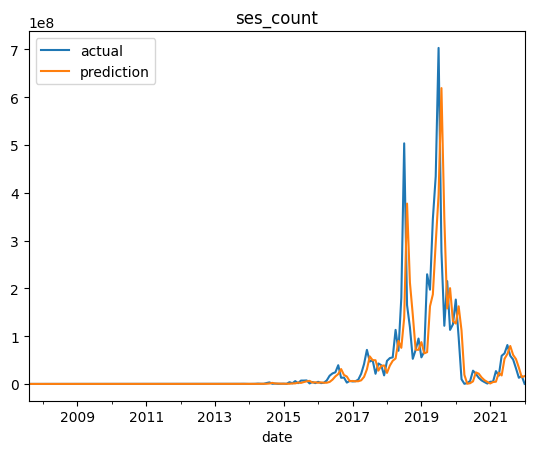

In [20]:
def temp(x):
    time_series_for_arimax = negative_box_cox_diff.reindex(x.index)
    train_exog = negative_exog_variables.reindex(time_series_for_arimax.index)
    train_exog = train_exog.fillna(method='ffill')
    test_exog = negative_exog_variables.reindex(x.index[-1:])
    test_exog = test_exog.fillna(method='ffill')
    return ARIMA(time_series_for_arimax, order=(1, 1, 1), exog=train_exog.iloc[:len(x)]).fit().forecast(1, exog=test_exog).iloc[0]

evaluate_and_plot_best(negative_reviews_per_month, lambda_negative, comparison='MSE', extra_models={'arimax': temp}, extra_variables=['count'])

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


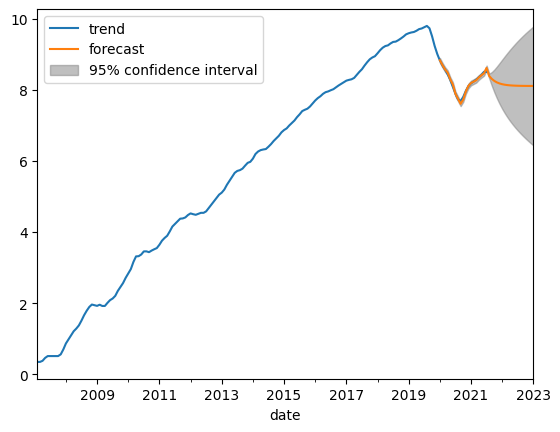

In [257]:
# Plot future forecast for the best model with probability intervals

# Model ARIMAX
variable = 'trend'

exam_data = negative_reviews_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

train_exog = negative_exog_variables.reindex(train.index)
train_exog = train_exog.fillna(method='ffill')

# predictions for the next 12 months
model = ARIMA(train, order=(1,1,1), exog=train_exog)
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', exog=[0]*18, ax=ax)
plt.show()

#### Positive reviews

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dat

Best model: holt_linear_damped_trend
MSE: 0.001997152343952568


Model         MAE           MSE        RMSE  \
0          baseline_mean_trend    3.580416     15.080115    3.883312   
1        baseline_mean_box_cox  189.631386  72635.689619  269.510092   
2          baseline_mean_count  156.010253  51281.524980  226.454245   
3        baseline_median_trend    3.384928     13.367385    3.656143   
4      baseline_median_box_cox  183.274580  68563.323251  261.845991   
5        baseline_median_count  183.269841  68561.767196  261.843020   
6         baseline_naive_trend    0.095932      0.013364    0.115603   
7       baseline_naive_box_cox   30.312169   2482.534392   49.825038   
8         baseline_naive_count   30.312169   2482.534392   49.825038   
9                    ses_trend    0.095932      0.013364    0.115603   
10                 ses_box_cox   30.421160   2642.257934   51.402898   
11                   ses_count   30.484827   2591.709756   50.908838   
12    holt_linear_damped_trend    0.030344      0.001997    0.044690   
13  holt_linear_damped_box_cox   30.500891   2750.113304   52.441523   
14    holt_linear_damped_count   30.768244   2644.263370   51.422401   
15                arimax_trend    0.095932      0.013364    0.115603   
16              arimax_box_cox   30.312169   2482.534392   49.825038   
17                arimax_count   30.312169   2482.534392   49.825038   

         MAPE        MASE  
0   42.844925   37.987966  
1   75.241538  370.794720  
2   63.976665    5.437792  
3   41.188368   35.913851  
4   74.267999  358.364973  
5   76.183425    6.387935  
6    1.587338    1.017828  
7   23.483750   59.270739  
8   26.513111    1.056541  
9    1.587338    1.017828  
10  22.366318   59.483854  
11  25.093294    1.062559  
12   0.507926    0.321951  
13  22.793004   59.639754  
14  25.701753    1.072438  
15   1.587338    1.017828  
16  23.483750   59.270739  
17  26.513111    1.056541

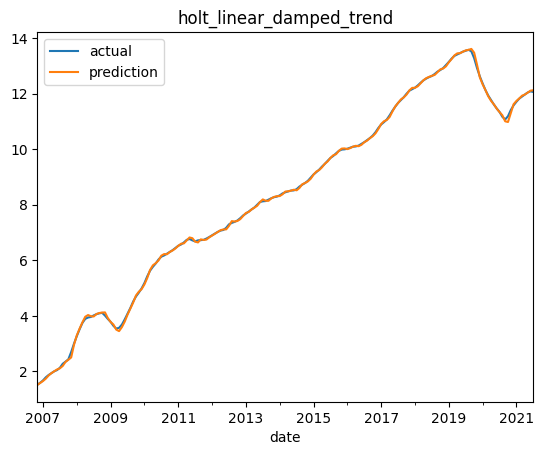

In [221]:
# according to arima.ipybn, the best model for ARIMAX is (0, 1, 0)

def temp(x):
    train_exog = positive_exog_variables.reindex(x.index)
    train_exog = train_exog.fillna(method='ffill')
    test_exog = positive_exog_variables.reindex(x.index[-1:])
    test_exog = test_exog.fillna(method='ffill')
    return ARIMA(x, order=(0, 1, 0), exog=train_exog.iloc[:len(x)]).fit().forecast(1, exog=test_exog).iloc[0]

evaluate_and_plot_best(positive_reviews_per_month, lambda_positive, comparison='MSE', extra_models={'arimax': temp}, extra_variables=['count'])

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


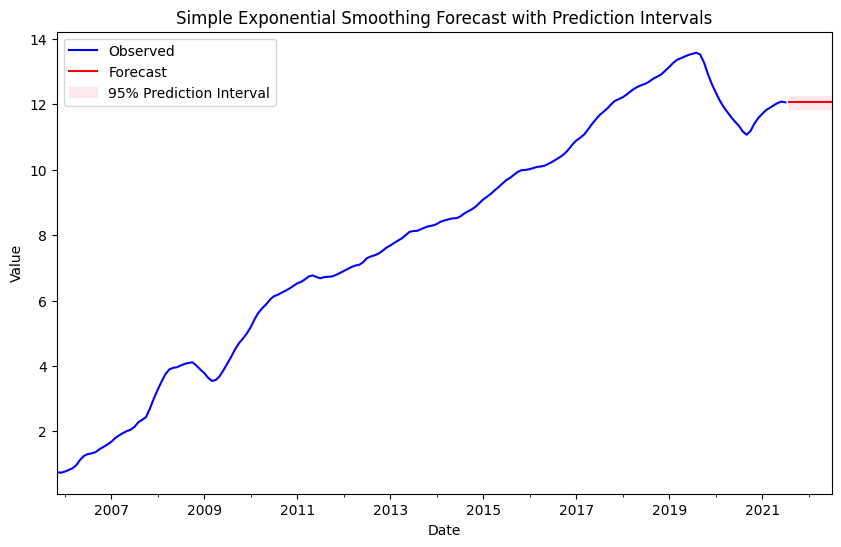

In [259]:
# Plot future forecast for the best model with probability intervals

# Model Holt Linear Damped
variable = 'trend'

exam_data = positive_reviews_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# Fit the SimpleExponentialSmoothing model
model = SimpleExpSmoothing(train)
results = model.fit()

# Generate forecasts for the next 12 months
forecast_periods = 12
forecast = results.forecast(forecast_periods)

# Calculate prediction intervals
alpha = 0.05
z = 1.96  # Z-score for 95% confidence interval

# Calculate standard error of forecast
residuals = train - results.fittedvalues
stderr = residuals.std()

# Generate confidence intervals
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_periods+1, freq='M')[1:]
conf_int = z * stderr

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
train.plot(ax=ax, label='Observed', color='blue')
forecast.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals
ax.fill_between(forecast_index, forecast - conf_int, forecast + conf_int, color='pink', alpha=0.3, label='95% Prediction Interval')

# Add labels and legend
ax.set_title('Simple Exponential Smoothing Forecast with Prediction Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='upper left')

# Show the plot
plt.show()

#### Neutral reviews

/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.1

Best model: holt_linear_damped_trend
MSE: 0.0017128692351178287


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Model        MAE          MSE       RMSE       MAPE  \
0          baseline_mean_trend   1.975337     4.484071   2.117563  46.111150   
1        baseline_mean_box_cox  24.860227  1107.632376  33.281111  66.047675   
2          baseline_mean_count  20.402634   789.886471  28.104919        inf   
3        baseline_median_trend   1.758547     3.560775   1.887002  42.813461   
4      baseline_median_box_cox  23.254512   976.644823  31.251317  63.240979   
5        baseline_median_count  23.252688   976.583333  31.250333        NaN   
6         baseline_naive_trend   0.064645     0.007221   0.084977   2.145460   
7       baseline_naive_box_cox   7.069892    96.037634   9.799879  30.047173   
8         baseline_naive_count   7.069892    96.037634   9.799879        NaN   
9                    ses_trend   0.064645     0.007221   0.084977   2.145460   
10                 ses_box_cox   6.578380    91.205863   9.550176  27.906539   
11                   ses_count   6.551624    90.647891   9.520919        inf   
12    holt_linear_damped_trend   0.030494     0.001713   0.041387   1.189853   
13  holt_linear_damped_box_cox   6.644601    96.392893   9.817988  28.363255   
14    holt_linear_damped_count   6.584294    91.631992   9.572460        inf   
15                arimax_trend   0.064645     0.007221   0.084977   2.145460   
16              arimax_box_cox   7.069892    96.037634   9.799879  30.047173   
17                arimax_count   7.069892    96.037634   9.799879        NaN   

         MASE  
0   31.532945  
1   52.419939  
2    3.054194  
3   28.072249  
4   49.034150  
5    3.480836  
6    1.031955  
7   14.907480  
8    1.058335  
9    1.031955  
10  13.871083  
11   0.980752  
12   0.486792  
13  14.010715  
14   0.985643  
15   1.031955  
16  14.907480  
17   1.058335

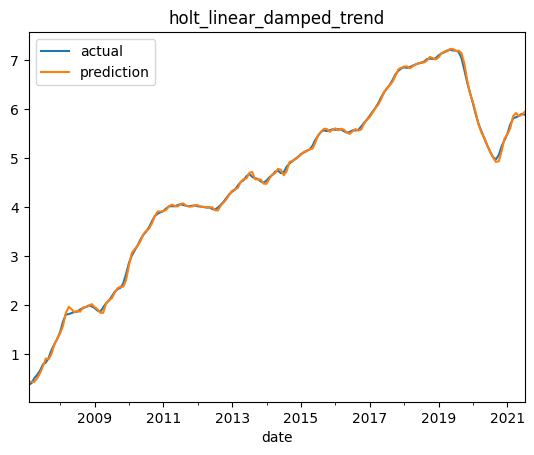

In [223]:
# according to arima.ipybn, the best model for ARIMAX is (1, 1, 2)

def temp(x):
    train_exog = neutral_exog_variables.reindex(x.index)
    train_exog = train_exog.fillna(method='ffill')
    test_exog = neutral_exog_variables.reindex(x.index[-1:])
    test_exog = test_exog.fillna(method='ffill')
    return ARIMA(x, order=(0, 1, 0), exog=train_exog.iloc[:len(x)]).fit().forecast(1, exog=test_exog).iloc[0]

evaluate_and_plot_best(neutral_reviews_per_month, lambda_neutral, comparison='MSE', extra_models={'arimax': temp}, extra_variables=['count'])

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


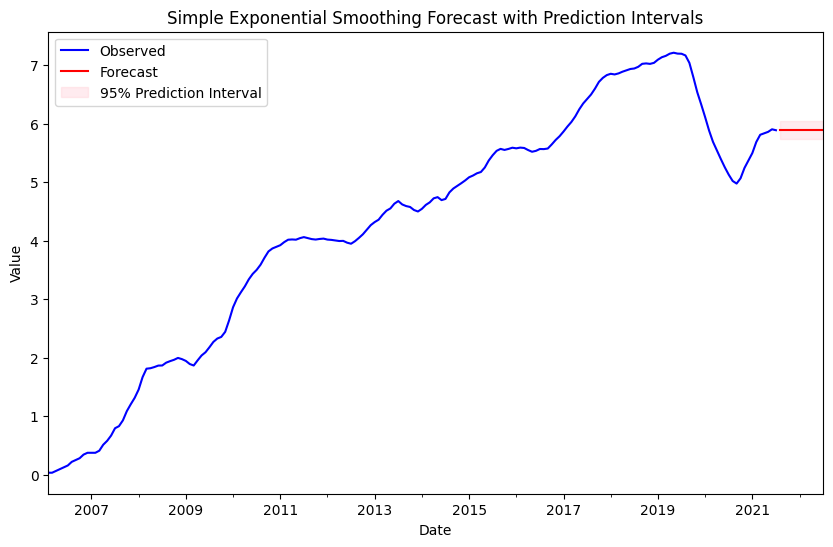

In [258]:
# Plot future forecast for the best model with probability intervals

# Model Holt Linear Damped
variable = 'trend'

exam_data = neutral_reviews_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# Fit the SimpleExponentialSmoothing model
model = SimpleExpSmoothing(train)
results = model.fit()

# Generate forecasts for the next 12 months
forecast_periods = 12
forecast = results.forecast(forecast_periods)

# Calculate prediction intervals
alpha = 0.05
z = 1.96  # Z-score for 95% confidence interval

# Calculate standard error of forecast
residuals = train - results.fittedvalues
stderr = residuals.std()

# Generate confidence intervals
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_periods+1, freq='M')[1:]
conf_int = z * stderr

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
train.plot(ax=ax, label='Observed', color='blue')
forecast.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals
ax.fill_between(forecast_index, forecast - conf_int, forecast + conf_int, color='pink', alpha=0.3, label='95% Prediction Interval')

# Add labels and legend
ax.set_title('Simple Exponential Smoothing Forecast with Prediction Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='upper left')

# Show the plot
plt.show()

#### Sentiment

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dat

Best model: arma_trend
MSE: 1.9585673859931782e-05


/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model       MAE       MSE      RMSE       MAPE  \
0            baseline_mean_trend  0.077331  0.007264  0.085229  20.848857   
1          baseline_mean_box_cox  0.174802  0.044230  0.210310  46.740644   
2        baseline_mean_sentiment  0.142420  0.032713  0.180868  38.464680   
3          baseline_median_trend  0.052515  0.004168  0.064557  14.845354   
4        baseline_median_box_cox  0.119177  0.031497  0.177475  32.168637   
5      baseline_median_sentiment  0.119153  0.031484  0.177436  32.164055   
6           baseline_naive_trend  0.003773  0.000040  0.006342   1.183167   
7         baseline_naive_box_cox  0.100776  0.023136  0.152106  23.471432   
8       baseline_naive_sentiment  0.100776  0.023136  0.152106  23.471432   
9                      ses_trend  0.003773  0.000040  0.006342   1.183167   
10                   ses_box_cox  0.087349  0.018713  0.136795  21.387516   
11                 ses_sentiment  0.086586  0.018289  0.135237  21.084688   
12      holt_linear_damped_trend  0.003139  0.000027  0.005196   0.997787   
13    holt_linear_damped_box_cox  0.101534  0.019795  0.140694  23.813726   
14  holt_linear_damped_sentiment  0.095863  0.018185  0.134850  22.695224   
15                    arma_trend  0.002718  0.000020  0.004426   0.847004   
16                  arma_box_cox  0.108765  0.023972  0.154828  28.419463   
17                arma_sentiment  0.099722  0.020959  0.144773  25.393819   

         MASE  
0   17.890078  
1    3.339894  
2    1.420883  
3   12.149108  
4    2.277089  
5    1.188758  
6    0.872849  
7    1.925500  
8    1.005414  
9    0.872849  
10   1.668944  
11   0.863839  
12   0.726292  
13   1.939980  
14   0.956398  
15   0.628735  
16   2.078141  
17   0.994901

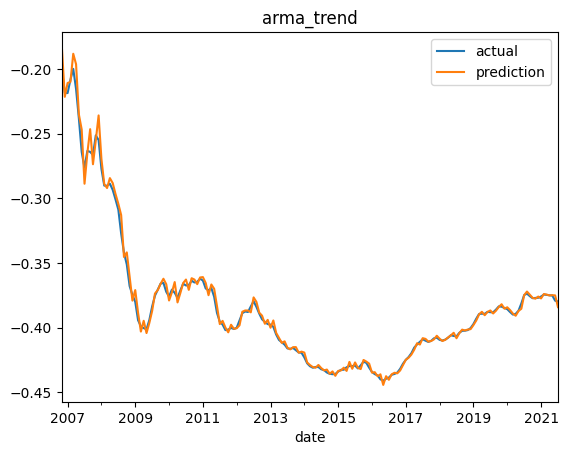

In [225]:
# according to arima.ipybn, the best model for ARMA is (2, 1)
evaluate_and_plot_best(sentiment_per_month, lambda_sentiment, comparison='MSE', extra_models={'arma': lambda x: ARIMA(x, order=(2, 0, 1)).fit().forecast(1).iloc[0]}, extra_variables=['sentiment'])

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


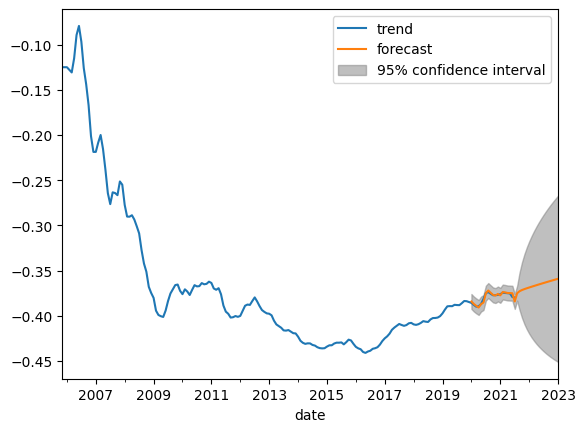

In [236]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = sentiment_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(2,0,1))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()

#### Restaurant sentiment

/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib

Best model: arma_trend
MSE: 4.529734124644221e-05


/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Model       MAE       MSE      RMSE      MAPE  \
0            baseline_mean_trend  0.053095  0.003733  0.061099  4.593707   
1          baseline_mean_box_cox  0.112585  0.028715  0.169456  4.629035   
2        baseline_mean_sentiment  0.116348  0.029741  0.172457       inf   
3          baseline_median_trend  0.039191  0.002144  0.046306  3.382915   
4        baseline_median_box_cox  0.121829  0.041308  0.203244  5.116255   
5      baseline_median_sentiment  0.121837  0.041311  0.203252       inf   
6           baseline_naive_trend  0.005683  0.000080  0.008923  0.481142   
7         baseline_naive_box_cox  0.115100  0.031457  0.177362  4.663962   
8       baseline_naive_sentiment  0.115100  0.031457  0.177362       inf   
9                      ses_trend  0.005683  0.000080  0.008923  0.481142   
10                   ses_box_cox  0.104304  0.027473  0.165750  4.228393   
11                 ses_sentiment  0.104665  0.027564  0.166024       inf   
12      holt_linear_damped_trend  0.004521  0.000059  0.007694  0.382894   
13    holt_linear_damped_box_cox  0.104330  0.027916  0.167080  4.226691   
14  holt_linear_damped_sentiment  0.104941  0.028213  0.167968       inf   
15                    arma_trend  0.004283  0.000045  0.006730  0.363109   
16                  arma_box_cox  0.117521  0.028358  0.168398  4.747601   
17                arma_sentiment  0.117283  0.028106  0.167649       inf   

        MASE  
0   7.521067  
1   1.491978  
2   0.979610  
3   5.551614  
4   1.614478  
5   1.025826  
6   0.804982  
7   1.525304  
8   0.969104  
9   0.804982  
10  1.382234  
11  0.881242  
12  0.640374  
13  1.382581  
14  0.883573  
15  0.606690  
16  1.557385  
17  0.987483

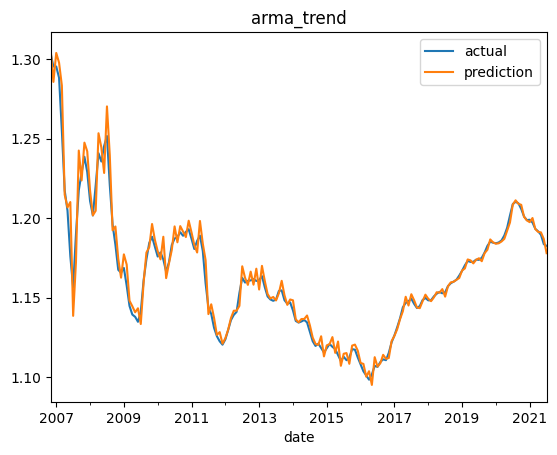

In [227]:
# according to arima.ipybn, the best model for ARMA is (2, 1)
evaluate_and_plot_best(sentiment_restaurants_per_month, lambda_restaurants, comparison='MSE', extra_models={'arma': lambda x: ARIMA(x, order=(2, 0, 1)).fit().forecast(1).iloc[0]}, extra_variables=['sentiment'])

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


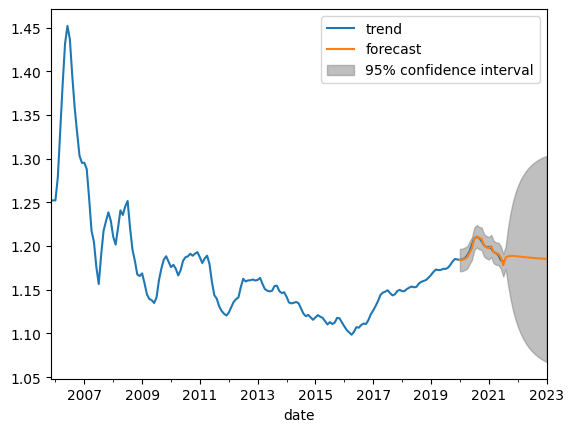

In [235]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = sentiment_restaurants_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(2,0,1))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()

#### Nightlife sentiment

/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib

Best model: arma_trend
MSE: 0.0001234853901221453


Model       MAE       MSE      RMSE      MAPE  \
0            baseline_mean_trend  0.035561  0.002352  0.048501  3.083172   
1          baseline_mean_box_cox  0.177145  0.086235  0.293659  8.312886   
2        baseline_mean_sentiment  0.172264  0.084833  0.291261       inf   
3          baseline_median_trend  0.035930  0.002400  0.048985  3.071864   
4        baseline_median_box_cox  0.183417  0.127160  0.356595  9.330452   
5      baseline_median_sentiment  0.183289  0.127028  0.356410       inf   
6           baseline_naive_trend  0.009609  0.000357  0.018890  0.834602   
7         baseline_naive_box_cox  0.168036  0.096202  0.310165  7.369930   
8       baseline_naive_sentiment  0.168036  0.096202  0.310165       inf   
9                      ses_trend  0.009609  0.000357  0.018890  0.834602   
10                   ses_box_cox  0.155035  0.088769  0.297941  6.839762   
11                 ses_sentiment  0.152887  0.087525  0.295846       inf   
12      holt_linear_damped_trend  0.007312  0.000182  0.013505  0.636745   
13    holt_linear_damped_box_cox  0.157446  0.090160  0.300267  6.946178   
14  holt_linear_damped_sentiment  0.155170  0.089076  0.298456       inf   
15                    arma_trend  0.007022  0.000123  0.011112  0.612494   
16                  arma_box_cox  0.182702  0.099220  0.314992  8.035219   
17                arma_sentiment  0.177397  0.091392  0.302311       inf   

        MASE  
0   3.111521  
1   1.624353  
2   1.020555  
3   3.143805  
4   1.681867  
5   1.085874  
6   0.840741  
7   1.540832  
8   0.995509  
9   0.840741  
10  1.421614  
11  0.905759  
12  0.639831  
13  1.443717  
14  0.919283  
15  0.614380  
16  1.675307  
17  1.050967

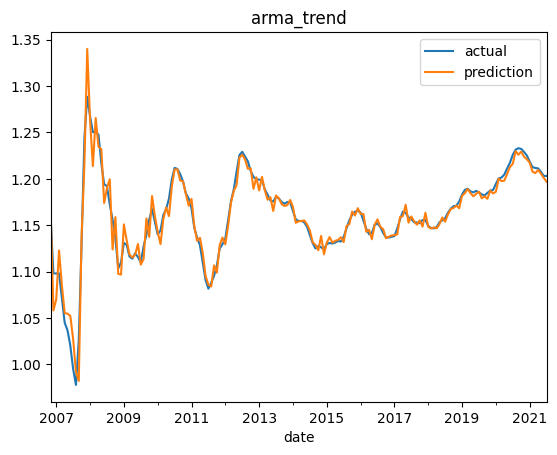

In [229]:
# according to arima.ipybn, the best model for ARMA is (2, 2)
evaluate_and_plot_best(sentiment_nightlife_per_month, lambda_nightlife, comparison='MSE', extra_models={'arma': lambda x: ARIMA(x, order=(2, 0, 2)).fit().forecast(1).iloc[0]}, extra_variables=['sentiment'])

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


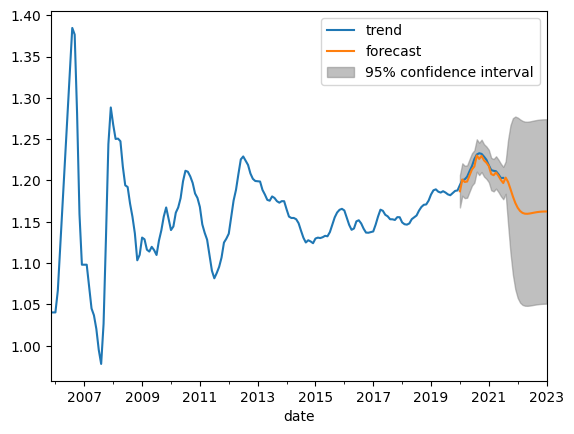

In [234]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = sentiment_nightlife_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(2,0,2))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()

#### Breakfast & brunch sentiment

/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.

Best model: arma_trend
MSE: 6.529830522967218e-05


/var/folders/td/xwj23wjj3p909mcvhbt6jgy00000gn/T/ipykernel_40954/1144694268.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Model       MAE       MSE      RMSE      MAPE  \
0            baseline_mean_trend  0.057972  0.004842  0.069586  5.116062   
1          baseline_mean_box_cox  0.172762  0.061607  0.248208  7.442919   
2        baseline_mean_sentiment  0.176361  0.063737  0.252461       inf   
3          baseline_median_trend  0.045017  0.003401  0.058319  3.959644   
4        baseline_median_box_cox  0.196721  0.089113  0.298517  8.546060   
5      baseline_median_sentiment  0.196726  0.089120  0.298529       inf   
6           baseline_naive_trend  0.007555  0.000120  0.010935  0.655088   
7         baseline_naive_box_cox  0.177765  0.067870  0.260519  7.283278   
8       baseline_naive_sentiment  0.177765  0.067870  0.260519       NaN   
9                      ses_trend  0.007555  0.000120  0.010935  0.655088   
10                   ses_box_cox  0.163666  0.056077  0.236807  6.713926   
11                 ses_sentiment  0.164097  0.056531  0.237762       inf   
12      holt_linear_damped_trend  0.006986  0.000092  0.009594  0.604679   
13    holt_linear_damped_box_cox  0.170829  0.059193  0.243297  6.919325   
14  holt_linear_damped_sentiment  0.171555  0.059503  0.243933       inf   
15                    arma_trend  0.005547  0.000065  0.008081  0.480494   
16                  arma_box_cox  0.168472  0.059529  0.243987  7.050918   
17                arma_sentiment  0.168503  0.059483  0.243892       inf   

        MASE  
0   6.871973  
1   1.616371  
2   1.053070  
3   5.336284  
4   1.840534  
5   1.174672  
6   0.895518  
7   1.663175  
8   1.061453  
9   0.895518  
10  1.531267  
11  0.979843  
12  0.828159  
13  1.598287  
14  1.024372  
15  0.657505  
16  1.576233  
17  1.006149

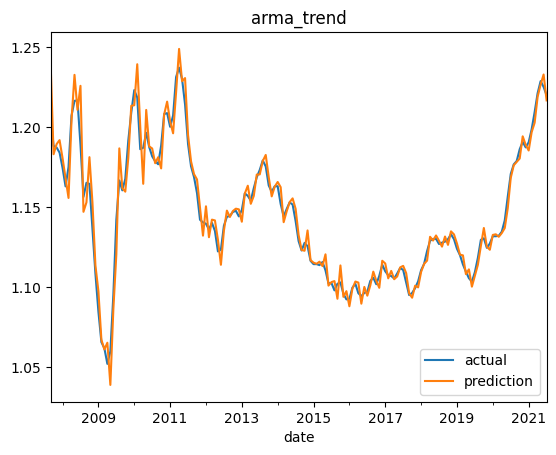

In [231]:
# according to arima.ipybn, the best model for ARMA is (2, 1)
evaluate_and_plot_best(sentiment_breakfast_brunch_per_month, lambda_breakfast_brunch, comparison='MSE', extra_models={'arma': lambda x: ARIMA(x, order=(2, 0, 1)).fit().forecast(1).iloc[0]}, extra_variables=['sentiment'])

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


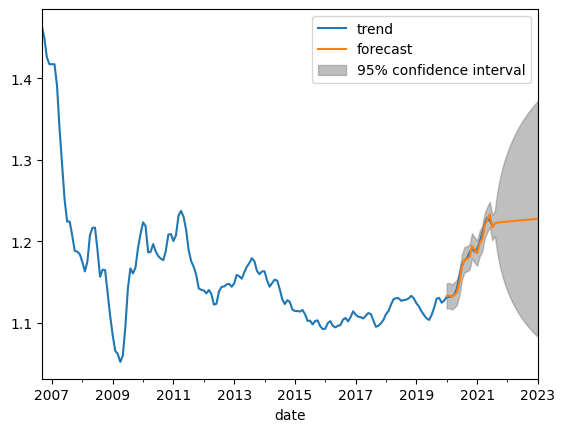

In [233]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = sentiment_breakfast_brunch_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(2,0,1))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()